# SeSiMe
(Sentence/Sequence Similarity Measure)

## This notebook:  In-depth comparison of spectrum-spectrum similarity scoring.

+ 'Labeled data' from GNPS Dataset of 11134 spectra with unique smiles.

## Part 1: Importing, first pre-processing 
Loading data, importing packages, first pre-processing steps...

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0.01, #0
                 exp_intensity_filter = None, #0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


### Note
In total it would be about 100.000 words. Many occur only once in the entire corpus and are hence filtered out. Otherwise they can end up being placed largely randomly in word-space...

Few also are filtered out because they occur too often (in more than 20% of the spectra). Those words have little discriminative power and are hence ignored. Might still be worth keeping them in for comparison (as I expect that they will anyway be downrated a lot later on by using the tfidf for weighing)!

## Part 2: Train Word2Vec model and derive spectrum vectors
### 1) Model trained on unique smiles dataset only.

In [6]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [7]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

All 'words' of the given documents were found in the trained word2vec model.
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents. of  9550  documents. of  9550  documents.

## Part 3: Calculate/load the different score matrices
### all-vs-all matrix of spectrum-spectrum similarity scores
+ Word2Vec-centroid similarity scores
+ Cosine similarity scores
+ Modified cosine scores (MolNet)
+ Molecular similarity scores based on molecular fingerprints. Unless stated otherwise: Dice score based on morgen-3 fingerprints.

### Calculate/load modified cosine score (here using Hungarian algorithm)
+ Be aware: calculating those is **very slow** !
+ Function below will load the given file and only calculate the scores from scratch if no such file is found.

#### Modified cosine score (using gnps default 1 parameters -- high tol)

In [ ]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol05_minmatch6_fast.npy"
molnet_sim = MS_functions.molnet_matrix(spectra, 
                  tol = 0.5, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 6, 
                  min_intens = 0.01,
                  filename = filename,
                  method = 'fast', #'hungarian',
                  num_workers = 8,
                  safety_points = 50)

#### Modified cosine score (using gnps default 2 parameters -- low tol)

In [9]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol002_minmatch6_fast.npy"
molnet_sim = np.load(filename)

In [10]:
# or: calculate from scratch
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol002_minmatch6_fast.npy"
molnet_sim = MS_functions.molnet_matrix(spectra, 
                  tol = 0.02, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 6, 
                  min_intens = 0.01,
                  filename = filename,
                  method = 'fast',
                  num_workers = 8,
                  safety_points = 50)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\data\MolNet_gnps_uniquesmiles_dec2_tol05_minmatch6_fast.npy
MolNet scores will be calculated from scratch.
Calculate pairwise MolNet scores by  8 number of workers.


  Calculated MolNet for pair  1111 -- 5665 . (  21.92  % done).21.89  % done).). % done).). 1090 -- 8094 . (  21.54  % done). % done). . (  0.39  % done). 6152 . (  0.47  % done).0.62  % done).  . (  0.8  % done). Calculated MolNet for pair  38 -- 7840 . (  0.81  % done).40 -- 8819 . (  0.86  % done). % done). . (  1.08  % done).4852 . (  1.3  % done). 9394 . (  1.38  % done). 1910 . (  1.38  % done).67 -- 3427 . (  1.41  % done).1.41 Calculated MolNet for pair  67   % done).-- 7427 . (  1.41  % done). 1.43  % done). Calculated MolNet for pair  69 -- 464 . (  1.44  % done).1.47  % done).-- 2027 . (  1.51  % done).  1.51 1.51  % done). % done). 1.67  % done). 1239 . (  1.67  % done). 7302 . (  1.73 1.73  % done).  % done).  1.94  % done).2.24  % done). Calculated MolNet for pair  118 -- 9120 . (  2.48  % done). 119 -- 8689 . (  2.5  % done).2.54  % done). Calculated MolNet for pair  123 -- 6975 . (  2.57  % done). 2.58  % done). Calculated MolNet for pair   % done).  % done).  Calculate

  Calculated MolNet for pair  5656 -- 7195 . (  83.38  % done).83.34  % done).3  % done).).% done). 7150 . (  81.36  % done)..5.61  % done).). Calculated MolNet for pair  4115 -- 5419 -- 6419 . (  67.62  % done). . (  67.63  % done).. (  67.69  % done).  . (  67.7  % done).-- 9549 . (  67.73  % done).434467.9  % done). 67.91  % done). 4141 -- 4460 . (  67.93 7460 . (  67.93  % done).8460 . (  67.93  % done).4144 -- 7239 . (  67.97  % done).-- 7430 . (  67.99  % done).67.99  % done).-- 9430 . (  68.0  % done). 68.0  % done).68.06  % done).. (  68.07  % done).. (  68.09  % done).  % done). % done).68.16  % done).. (  68.16  % done).-- 5715 . (  68.19  % done).. (  68.26  % done). 68.27  % done). % done). 9030 . (  68.37  % done).68.4  % done). % done). . (  68.51  % done).4192 -- 4927  7800 . (  68.61  % done). Calculated MolNet for pair  4202 -- 7402 . (  68.65  % done). 68.69  % done). Calculated MolNet for pair  4206 -- 8020 . (   Calculated MolNet for pair  4207 -- 6677 . (  68.71  %

  Calculated MolNet for pair  8873 -- 9350 . (  99.51  % done). 98.75  % done). % done). done).9 -- 8414 . (  97.92  % done)...4  % done).5666 -- 9310 . (  83.47  % done).83.57  % done). % done). . (    % done).. (  83.65  % done).7699 . (  83.75  % done).. (  83.87  % done).5714 -- 7054 . (  83.87  % done).  8924 . (  83.97  % done).---- 7277 6277 . (  83.98  % done). . (  83.98  % done).9277 . (  83.99  % done). % done). % done). Calculated MolNet for pair  5740 -- 8669 . (  84.1  % done). 84.16  % done).5756 -- 5845 . (  84.22  % done).84.48  % done).84.57  % done). 9400 . (  84.58  % done).  % done). -- 7909 . (  84.62  % done). 8380 . (  84.77  % done). . (  84.77  % done).  % done).. (  84.82  % done). % done).  % done).-- 8495 . (  85.05  % done).9495 . (  85.05  % done).. (  85.08  % done).. (  85.11  % done).. (  85.24  % done).9135 . (  85.27  % done).. (   85.31  % done). % done). 85.37  % done). Calculated MolNet for pair  5910 -- 9504 . (  85.49  % done). Calculated MolNet

  Calculated MolNet for pair  9543 -- 9545 . (  100.01  % done). (  99.53  % done). 9449 . (  99.55  % done). 8934 -- 8944 . (  99.59  % done).9329 . (  99.6  % done).8943 -- 9445 . (  99.61  % done). -- 9102 . (  99.63  % done).8969 -- 9014 . (  99.64  % done).. (  99.65  % done). . (  99.68  % done).9010 -- 9054 . (  99.69  % done). -- 9125 . (  99.71  % done). % done). 99.89  % done).-- 9495 . (  99.91  % done). 9525 . (  99.99  % done).

#### Cosine score (using gnps default 2 parameters -- low tol)

In [8]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_dec2_tol002_minmatch6_fast.npy"
molnet_sim_hung = MS_functions.molnet_matrix(spectra, 
                  tol = 0.02, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 6, 
                  min_intens = 0.01,
                  filename = filename,
                  method = 'fast',
                  num_workers = 8,
                  safety_points = 50)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\data\MolNet_gnps_uniquesmiles_dec2_tol002_minmatch6_fast.npy
MolNet scores will be calculated from scratch.
Calculate pairwise MolNet scores by  8 number of workers.


  Calculated MolNet for pair  2144 -- 3239 . (  39.87  % done).-- 7700 . (  39.58  % done). 2123 -- 6975 . (  39.53  % done)... % done).0.66  % done). 0.76  % done). 0.82  % done). . (  0.92  . (  0.93  % done).. (  1.29  % done).62 -- 8852 . (  1.31  % done). 7464 . (  5599 . (  1.58  % done).75 -- 6599 . (  1.58  % done).1.89  % done). 1.93  % done). % done). Calculated MolNet for pair  102 -- 7152 . (  2.14  % done). Calculated MolNet for pair  115 -- 9419 . (  2.41  % done). 2.49  % done). 6689 . (  2.49  % done). 4177 . (  2.75  % done). 132 -- 6177 . (  2.76  % done). 7929 . (  2.82  % done). Calculated MolNet for pair  138 -- 5690 . (  2.88  % done). % done). 6279 . (  2.9  % done).-- 7430 . (  3.05  % done).3.55524 . (  3.62  % done). -- 8775 . (  3.67  % done). 6090 . (  3.87  % done).187 -- 7727 . (  3.89  % done).. (  3.9  % done). . (  4.06  % done). 4.35  % done).6994 5969 . (  4.46  % done). 7969 . (  4.47  % done).8639 . (  4.55  % done). 224 -- 6999 . (  4.65  % done). 

  Calculated MolNet for pair  5356 -- 9245 . (  80.73  % done).  % done). MolNet for pair   % done). 5336 -- 7315 . (  80.54).Net for pair  3681 -- 8170 . (  62.25  % done).62.5  % done). Calculated MolNet for pair  3702 -- 8152 . (  . (  62.52  % done). Calculated MolNet for pair  3703 -- 7305 . (  62.53  % done).. (    % done).62.77 . (  62.79  % done). . (  63.19  % done). % done). % done).-- 5890 . (  63.26  % done).3762 -- 5102 . (  63.27  % done).-- 5529 . (  63.3  % done).3764 -- 7529 . (  63.31--8177 . (  63.34  % done). 9177 . (  63.35  % done).63.39  % done).  % done). 4949 . (  63.44  % done). 694963.57  % done).  % done). 3793 -- 4170 . (  63.66  % done).3796 -- 3905 . (  63.7  % done). 63.7  % done). 63.8  % done).. (  63.85  % done).  % done).. (  64.08  % done). Calculated MolNet for pair  3825 -- 9474 . (  64.08  % done).-- 9305 . (  64.12  % done).64.13  % done).8075 . ( . (  64.4  % done).3875 -- 5499 . (  64.7  % done). . (  64.86  % done).3896 -- 6555 . (  64.96  % 

  Calculated MolNet for pair  7563 -- 7615 . (  95.68  % done).   % done). % done).for pair  7535 -- 7629 . (  95.56  % done).-- 6290 . (  80.77  % done). Calculated MolNet for pair  5361 -- 8290 . (  80.77  % done). Calculated MolNet for pair  5367 -- 7177 . (  80.82  % done). Calculated MolNet for pair  . (  80.87  % done). -- 7230 . (  80.93  % done). 8552 . (  80.96  % done).5389 -- 8404 . (  81.03  % done).5389 -- 7404 . (  81.03  % done).. (  81.1  % done). -- 8849 . (  81.12  % done). -- 8820 6820 . (  81.18  % done).. (  81.18  % done).. (  81.3  % done). 5423 -- 7525 . (  81.34  % done).  Calculated MolNet for pair  5425 -- 8274 . (  81.36  % done).7274 . (  81.35  % done). 5426   % done).. (  81.38  % done).5432 8310 . (  81.43  % done).  81.46  % done).  % done). . (  81.48  % done).-- 7802 . (  81.64  % done).  % done).  % done).  Calculated MolNet for pair  5472 -- 7527 . (  81.78  % done).6299 . (  81.8  % done). 5475 -- 9299 . (  81.81  % done). . (  81.9  % done).. (  8

  Calculated MolNet for pair  9543 -- 9545 . (  100.01  % done).one).  % done). % done).ne). 8022 -- 8152 . (  97.45  % done).e). -- 8959 . (  95.75  % done). . (  95.82  % done). 7598 -- 7700 . (  95.83  % done).7799 . (  95.84  % done).7605 -- 8064 . (  % done).7607 -- 9177 . (  95.87  % done). % done). 96.06  % done).8740 . (  96.1  % done). . (  96.1  % done). % done).9525 . (  96.16  % done).8780 . (  96.17  % done). 9039 . (  96.18  % done).. (  96.2  % done). -- 9000 . (  96.26  % done). Calculated MolNet for pair  7712 -- 7727 . (  96.3  % done). 9100 . (  96.36  % done).. (  96.38  % done).. (  96.39  96.42  % done). % done). . (  96.44  % done). 96.5  % done). 96.52  % done). 96.52  % done). . (  96.53  % done). -- 7852 . (  96.79  % done). 7859 -- Calculated MolNet for pair  7883 -- 8135 . (  96.96  % done).8520 . (  97.0  % done). -- 9005 . (  97.04  % done). . (  97.06  % done).7935 -- 8829 . (  97.15  % done).7941 -- 8160 . (  97.17  % done).97.26  % done). 97.26  % done)

### Calculate/load cosine scores 
+ Calculating is much faster than the modified cosine score, but can still become **slow**, especially when using small tolerances and little filtering (resulting in many peaks...). 
+ Commented out for this notebook, so only loading...

In [9]:
#cosine_sim = MS_functions.cosine_matrix_fast(spectra,
#                                           tol = 0.1,
#                                           max_mz = 1000, 
#                                           min_mz = 0)

filename = PATH_SAVE_DATA + "cosine_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol01_minmatch1_minintens001_fast.npy"
cosine_sim = np.load(filename)

#### Cosine score (using gnps default 1 parameters)

In [11]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol05_minmatch6.npy"
cosine_sim = MS_functions.cosine_matrix(spectra, 
                                      tol = 0.5, 
                                      max_mz = 1000, 
                                      min_mz = 0, 
                                      min_match = 6, 
                                      min_intens = 0,
                                      filename = filename,
                                      num_workers = 4)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\data\Cosine_gnps_uniquesmiles_tol05_minmatch6.npy
Cosine scores will be calculated from scratch.
Calculate pairwise cosine scores by  4 number of workers.


  Calculated cosine for pair  959 -- 4869 . (  19.09  % done). % done). 18.98  % done).e).one). -- 4552 . (  18.29  % done).. % done). 8015 . (  0.25  % done). . (  0.3  % done). Calculated cosine for pair  15 -- 4869 . (  0.32  % done). -- 6869 . (  0.33  % done). . (  0.33  % done). 0.34  % done).-- 2802 . (  0.36  % done).18 -- 1270 . (  0.38  % done). % done). % done).   % done). Calculated cosine for pair  31 -- 7445 . (  Calculated cosine for pair  33 -- 5410 . (  0.7  % done). Calculated cosine for pair  33 -- 8410 . (  0.71  % done). 5894 . (  0.72  % done). % done). 0.78  % done).. (  0.89  % done).1.06  % done). % done).54 -- 7784 . (  1.14  % done).. (   1.17 % done).  % done). 1.18 5340 . (  1.29  % done). 4879 . (  1.35  % done). % done). Calculated cosine for pair  65 -- 8394 . (  1.37  % done).1.39  % done).. (  67 -- 2427 . (  1.4  % done).  Calculated cosine for pair  67 -- 7427 . (  1.41  % done). Calculated cosine for pair  68 -- 6945  Calculated cosine for pair  72 

  Calculated cosine for pair  3653 -- 5880 . (  61.88  % done).3647 -- 7277 . (  61.81  % done)..-- 8660 . (  60.75  % done)..ne). Calculated cosine for pair  2554 -- 9034 . (  46.35  % done).  Calculated cosine for pair  2555 -- 5039 . (  46.36  % done). 46.42  % done).2564 -- 9129 . (  46.51  % done). 46.6  % done). Calculated cosine for pair  2571 -- 8255 . (  46.61  % done).5277 . (  46.62  % done). -- 9300 . (  46.64  % done).  % done).3375  Calculated cosine for pair  2576 -- 6375 . (  46.68  % done).46.7  % done). -- 7765 . (  46.87  % done). Calculated cosine for pair  2591 Calculated cosine for pair  2595 -- 8059 . (  46.98  % done). Calculated cosine for pair  2600 -- 9299 . (  47.06  % done). Calculated cosine for pair   . (  47.12  % done). 2619 -- 4439 . (  47.33  % done).4652 . (  47.38  % done). 47.39  % done). 7874 . (  47.43  % done).. (  47.44  % done). . (  47.52  % done). 8345 . (  47.53  % done). . (  47.85  % done). % done).  % done).5579 . (  48.02  % done). Calc

  Calculated cosine for pair  4941 -- 5660 . (  76.71  % done).one).-- 7552 . (  76.48  % done).. -- 7395  (  71.36  % done)..or pair  3658 -- 9410 . (  61.95  % done). Calculated cosine for pair  3659 -- 4519 . (  61.95  % done).7965 . (  62.01  % done).. (  62.05  % done). Calculated cosine for pair  3667 -- 9427 . (  62.07  % done). -- 6664 . (  62.09  % done).. (   . (  62.1  % done).62.1  % done). 62.15  % done). 3676 -- 4525 . (  62.17  % done).62.2  % done).  62.23  % done). . (  62.3  % done).62.31  % done).65357550 . (  62.46  % done).7849 . (  62.49  % done). Calculated cosine for pair  3702 -- 6152 . (  62.51  % done). 9459 . (  62.54  % done).. (  62.6  % done). Calculated cosine for pair  . (  62.71  % done). 62.74  % done).. (  62.74  % done).-- 3749 . (  62.79  % done). 3726 -- 7100 . (  62.82 Calculated cosine for pair  3727 -- 9277 . (  62.84  % done). Calculated cosine for pair 63.0 -- 9225 . (  63.11  % done).3754 -- 6434 . (  63.18  % done).-- 7845 . (  63.2  % done

  Calculated cosine for pair  6919 -- 7289 . (  92.42  % done).% done).8654 . (  92.25  % done). (   90.63  % done). % done)..  76.76  % done).76.76  % done). 7425 . (  76.79  % done).76.81  % done). Calculated cosine for pair  . (  76.93  % done).76.93  % done).4974 -- % done).77.24  % done).77.26   % done).77.31  % done).  % done).7594 . (  77.4  % done).. (  77.42  % done). 6835 . (  77.47  % done).-- 5302 . (  77.48  % done).  % done). % done). % done). Calculated cosine for pair  5023 -- 8125 . (  77.54  % done).-- 6394 . (  77.65  % done). . (  77.81  % done).77.83  % done). 5054 -- 7284 . (  77.85  % done).77.87  % done). 5056 -- 9295 . (  77.87  % done).. (  77.89  % done). Calculated cosine for pair  5066 -- 6410 . (  77.96  % done). 8410 . (  77.97  % done). % done). Calculated cosine for pair  5081 -- 9270 . (  78.12  % done). % done).  Calculated cosine for pair  5083 -- 8335 . (  78.13  % done). Calculated cosine for pair  5087 -- 7477 . (  78.17  % done).  % done). 78.27 

  Calculated cosine for pair  9543 -- 9545 . (  100.01  % done).59  % done). 98.59  % done).(  97.26  % done).97.26  % done)..7524 92.51  % done).-- 9234 . (  92.57  % done). . (  92.6  % done).-- 9430 . (  92.62  % done). 92.64  % done).. (  92.64  % done). -- 7279 . (  92.65  % done). % done).8259 . (  92.76  % done).6990 -- 8044 . (  92.82  % done).--7004 -- 7309 . (    % done).7027  Calculated cosine for pair  7034 -- 9394 . (  93.07  % done).93.1  % done).93.15  % done). Calculated cosine for pair  7068 -- 9445 . (  93.26  % done).. (  93.32  % done).8404 . (  93.35  % done).7104 -- 93.458759 . (  93.45  % done).  % done). % done). Calculated cosine for pair  7114 -- 8354 . (  93.5  % done).  % done).7134 -- 8844 . (  93.61  % done).  % done).  % done).7147 -- 8527 . (  93.68  % done). . (  93.84  % done).7182 -- 9052 . (  93.86  % done).7191 -- 8785 . (  93.91  % done).9359 . (  93.93  % done).7201 -- 8250 . (  93.96  % done). 7228 -- 9205 . (  94.1  % done).--  . ( 8665 . (  94.

#### Cosine score (using gnps default 2 parameters, low tol)

In [10]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol002_minmatch6.npy"
cosine_sim = np.load(filename)

In [12]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol002_minmatch6.npy"
cosine_sim = MS_functions.cosine_matrix(spectra, 
                                      tol = 0.02, 
                                      max_mz = 1000, 
                                      min_mz = 0, 
                                      min_match = 6, 
                                      min_intens = 0,
                                      filename = filename,
                                      num_workers = 4)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\data\Cosine_gnps_uniquesmiles_tol002_minmatch6.npy
Cosine scores will be calculated from scratch.
Calculate pairwise cosine scores by  4 number of workers.


  Calculated cosine for pair  1585 -- 9154 . (  30.46  % done). (  30.35  % done).  % done).ne). -- 7889 . (  24.57  % done). 7 Calculated cosine for pair  16 -- 6335 . (  0.35  % done). . (  0.42  % done). % done). 23 -- 4625 . (  0.49  % done). 23 -- 5625 . (  0.49  % done). . (  0.69  % done).36 -- 7865 . (  0.77  % done). 0.82  % done). Calculated cosine for pair  43 -- 8295 . (  0.92  % done).0.94  % done). Calculated cosine for pair  59 -- 8319 . (  1.25  % done).-- 7505 . (  1.5  % done).83 -- 1835 . (  1.73  % done). Calculated cosine for pair  84 -- 7369 . (  1.77  Calculated cosine for pair  84 -- 9369 . (  1.77  % done).7440 . (  1.81  % done).-- 8440 . (  1.81  % done). Calculated cosine for pair   8600 . (  2.12  % done).2.13  % done). 124 -- 7549 . (  2.6  % done). 2.62  % done). . (  2.72  % done). 134 -- 8344 . (  2.8  % done).. (  2.83  % done).. (  2.85  % done).31022.93  % done). 144 -- 3239 . (  3.0  % done).. (  3.09  % done). Calculated cosine for pair  156 -- 944

  Calculated cosine for pair  5100 -- 8549 . (  78.3  % done)..76.88  % done)..ne). % done).).).4 -- 6794 . (  69.02  % done).).8125 . (  55.08  % done). Calculated cosine for pair    % done). % done).55.22  % done). Calculated cosine for pair  3160 -- 3379 . (  55.23  % done). 55.28  % done). . (  55.45  % done). . (  55.45  % done).. (  55.46  % done). 55.51  % done). 6685 . (  -- 4227 . (  55.61  % done). 3187 -- 6227 . (  55.62  % done).. (  55.65  % done). % done).3195 -- 8359 . (  55.73 3200 -- 6599 . (  55.8  % done). 7599. (  55.81  % done). . (  55.81  % done).7209 . (  55.86  % done). -- 9209 . (  55.86  % done).8177 . (  55.9  % done).3209 -- 4494 . (  55.92  % done).-- 5154 . (  55.93  % done).. (  56.0  % done). 56.24  % done). 3242 -- 4802 . (  56.38  % done). 3261 -- 7140 . (  56.65  % done). 56.67  % done). % done). 56.81  % done). . (  56.85  % done). % done).  Calculated cosine for pair  3278 -- 4380 . (  56.87  % done). 7380 . (  56.88  % done). 3282 -- 5302 . (  56.

  Calculated cosine for pair  9543 -- 9545 . (  100.01  % done).. (  97.55  % done)..93  % done).ne).7529 . (  80.53  % done).(  78.72  % done).  % done).78.79  % done).-- 7527 . (  78.8  % done). % done). 78.85  % done).5172 -- 7777 . (  79.0  % done). 79.0  % done). . (  79.1  % done).  % done). % done).-- 7152 . (  79.47  % done).. (  79.58  % done).  % done). 5246 -- 5580 . (  79.7  % done). 5255 -- 6889 . (  79.78  % done).. (  79.79  % done). Calculated cosine for pair  5258 -- 7010 . (  79.81  % done). 79.85  % done). 79.95  % done).80.04  % done). 8302 . (  80.04  % done).5283 -- 6035 . (  80.04  % done). 5284 -- 8769 . (  80.06  % done).  % done).5290 -- 9194 . (  80.12  % done). % done). 80.29  % done).-- 7727 . (  80.32  % done).80.36  % done).. (  80.37  % done). . (  80.37  % done).  % done).8630 . (  80.4  % done). 5322 -- 7402 . (  80.41  % done).5327 -- 9277 . (  80.46  % done).8055 . (  80.47  % done).5335 -- 8529 . (  80.53  % done). . (  80.58  % done). . (  80.65  %

#### Cosine score (tol = 0.02, min_match = 1)

In [16]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol002_minmatch1.npy"
cosine_sim = MS_functions.cosine_matrix(spectra, 
                                      tol = 0.02, 
                                      max_mz = 1000, 
                                      min_mz = 0, 
                                      min_match = 1, 
                                      min_intens = 0,
                                      filename = filename,
                                      num_workers = 4)

Complete cosine similarity scores found and loaded.


#### Cosine score (tol = 0.005, min_match = 1) --> Aim: same accuracy as 2 decimal word model

In [ ]:
filename = PATH_SAVE_DATA + "Cosine_gnps_uniquesmiles_tol0005_minmatch1.npy"
cosine_sim = MS_functions.cosine_matrix(spectra, 
                                      tol = 0.005, 
                                      max_mz = 1000, 
                                      min_mz = 0, 
                                      min_match = 1, 
                                      min_intens = 0.01,
                                      filename = filename,
                                      num_workers = 4)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\SeSiMe\data\Cosine_gnps_uniquesmiles_tol0005_minmatch1.npy
Cosine scores will be calculated from scratch.
Calculate pairwise cosine scores by  4 number of workers.
  Calculated cosine for pair  22 -- 9152 . (  0.48  % done). ). . (  0.18  % done).one). 0.22  % done). -- 7680 . (  0.46  % done).-- 8152 . (  0.48  % done).

### Calculate/load molecular similarity scores
+ first calculate molecular fingerprints
+ then calculate (or load if file exists) molecular similarity scores.  

Method for calculating fingerprints here can be "morgan1", "morgan2", "morgan3" or "daylight". For morgan fingerprints scores will be based on Dice scores. For "daylight" fingerprint it will be Tanimoto scores. 

In [11]:
molecules, fingerprints_m3, exclude_IDs = MS_functions.get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

In [12]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
molecular_similarities = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_m3,
                                                      filename = filename)

Molecular similarity scores found and loaded.


### Calculate all-vs-all matrix for Word2Vec scores 

In [13]:
from scipy import spatial
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

## Part 4:  Query: select possible spectral pairs of interest!
+ select cases based on cosine score, modified cosine score, word2vec-based score and actual molecular similarity.

### Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=low

In [14]:
pair_selection = np.where((cosine_sim > 0.8)
                          & (molnet_sim >  0.9)
                & (M_sim_ctr < 0.3)  
                & (molecular_similarities < 0.3))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (66,)  matching spectral pairs.


1094 1365
Word2Vec score:  0.12944257852694352
Cosine score:  0.9021622101564206
Modified cosine score:  0.9048668853085367
Molecular similarity:  0.21686746987951808
  Created documents for  2  of  2  spectra.

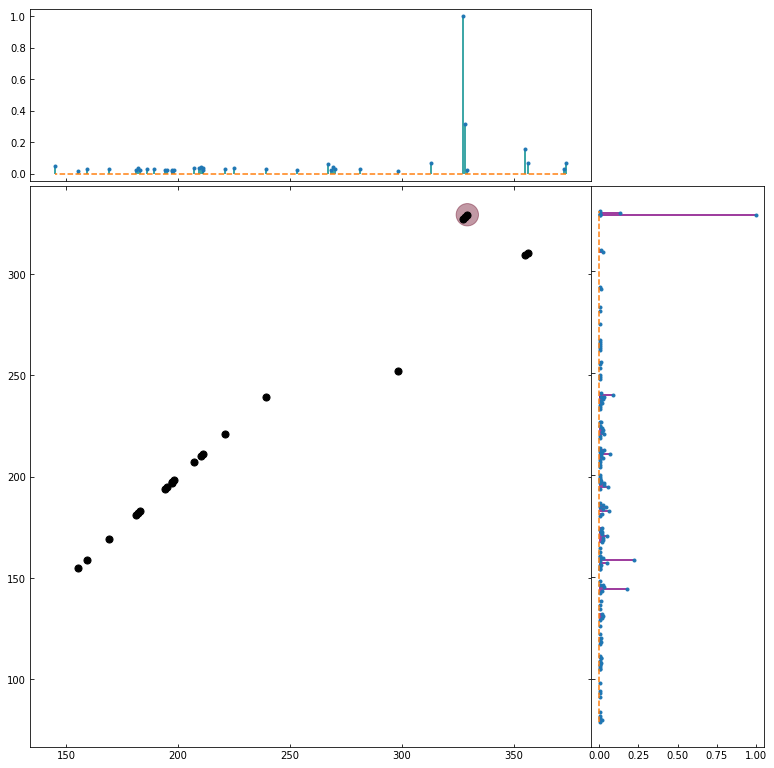

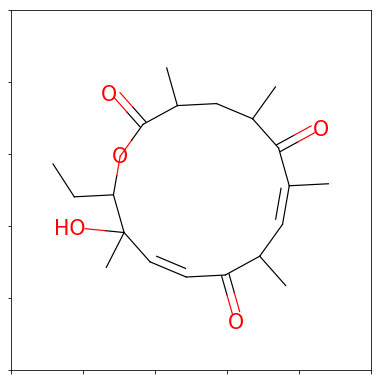

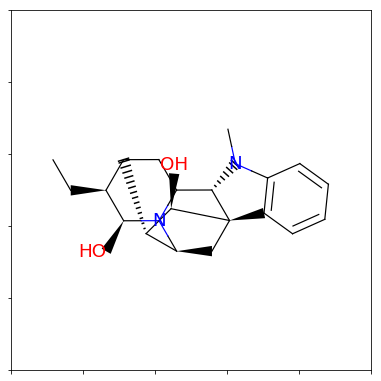

In [34]:
id = 9 #5, 6
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  tol = 0.02,
                                                  method = 'molnet', #'molnet'
                                                  wordsim_cutoff = 0.5,
                                                  plot_molecules = True)


In [23]:
from matplotlib import pyplot as plt
plt.savefig("in_depth_comparison.pdf")

<Figure size 432x288 with 0 Axes>

### Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=low

In [13]:
pair_selection = np.where((cosine_sim > 0.8)
                          & (molnet_sim_hung >  0.9)
                & (M_sim_ctr < 0.3)  
                & (molecular_similarities < 0.3))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (3108,)  matching spectral pairs.


3037 3064
Word2Vec score:  0.9054326180558431
Cosine score:  0.0
Modified cosine score:  0.0
Molecular similarity:  0.8302752293577982
  Created documents for  2  of  2  spectra.

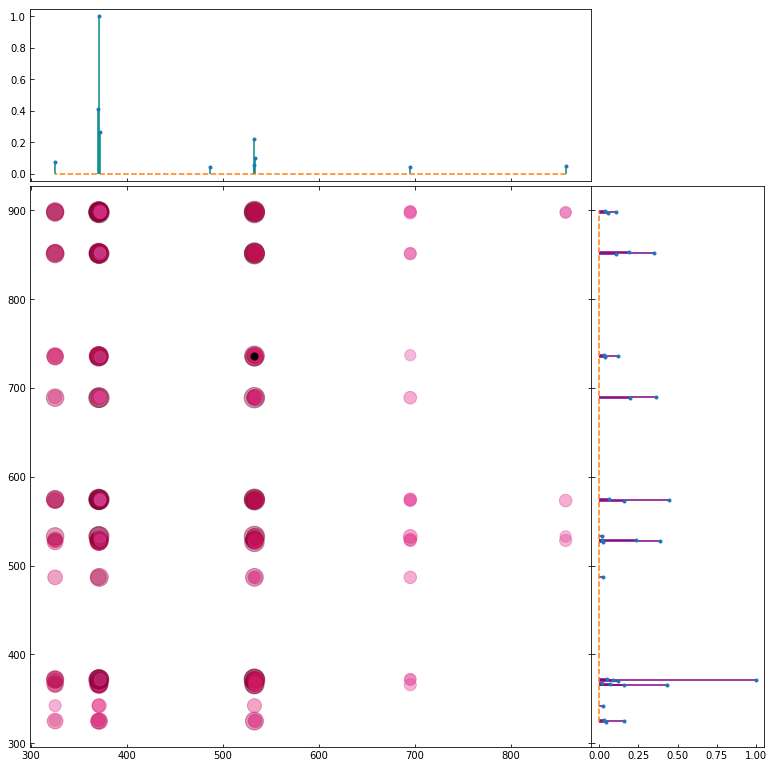

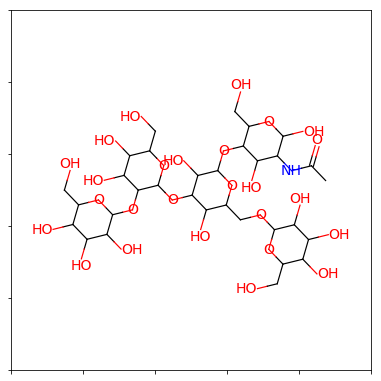

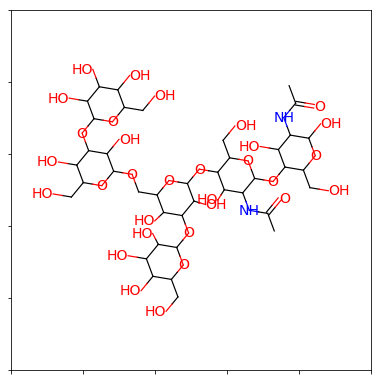

In [38]:
id = 70 #4, 6, 8, 60
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  tol = 0.02,
                                                  method = 'molnet', #'cosine'
                                                  wordsim_cutoff = 0.5,
                                                  plot_molecules = True)


### Example for: cosine=low, molnet=low, word2vec=high, molecular similarity=high

In [60]:
pair_selection = np.where((cosine_sim < 0.3)
                          & (molnet_sim < 0.3)
                          & (molnet_sim > 0)
                & (M_sim_ctr > 0.85) 
                & (M_sim_ctr < 0.98) 
                & (molecular_similarities > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (586,)  matching spectral pairs.


3746 3830
Word2Vec score:  0.8646585673730218
Cosine score:  0.14071492469820296
Modified cosine score:  0.1995846686458784
Molecular similarity:  0.8374760994263862
  Created documents for  2  of  2  spectra.

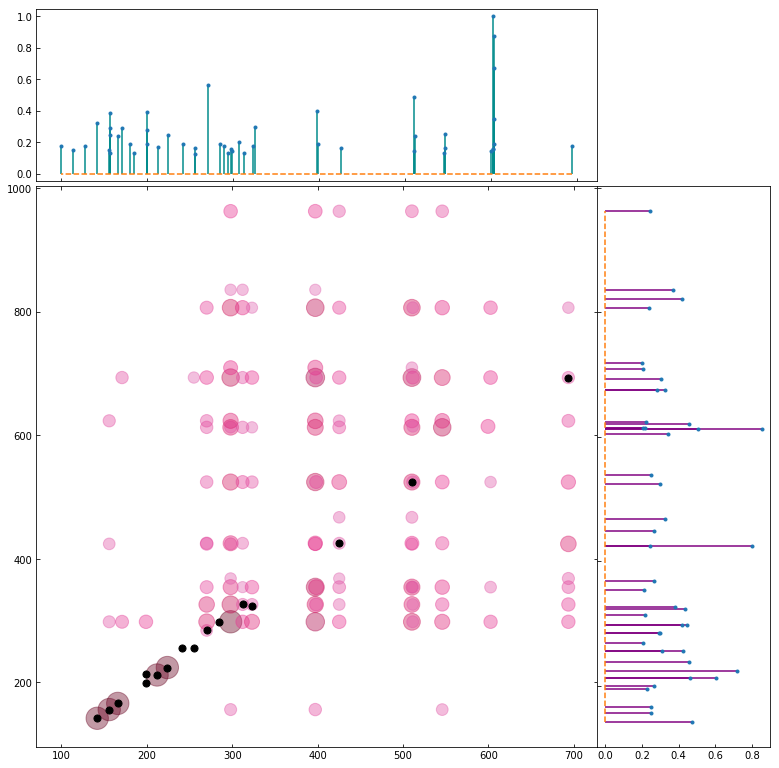

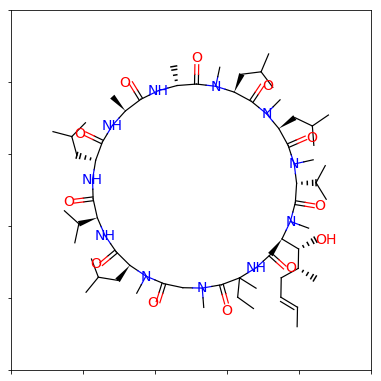

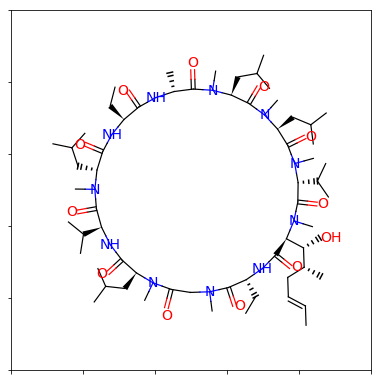

In [96]:
id = 184 #13, 0, 5, 8, 22
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  tol = 0.02,
                                                  method = 'molnet', #'cosine'
                                                  wordsim_cutoff = 0.5,
                                                  plot_molecules = True)

### Example for: cosine=low, molnet=high, word2vec=high, molecular similarity=high

In [36]:
pair_selection = np.where((cosine_sim < 0.3)
                          & (molnet_sim_hung > 0.9)
                & (M_sim_ctr > 0.85) 
                & (M_sim_ctr < 0.98) 
                & (molecular_similarities > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (186,)  matching spectral pairs.


109 737
Word2Vec score:  0.8907677851511832
Cosine score:  0.10295443935639959
Modified cosine score:  0.931103924362519
Molecular similarity:  0.863905325443787
  Created documents for  2  of  2  spectra.

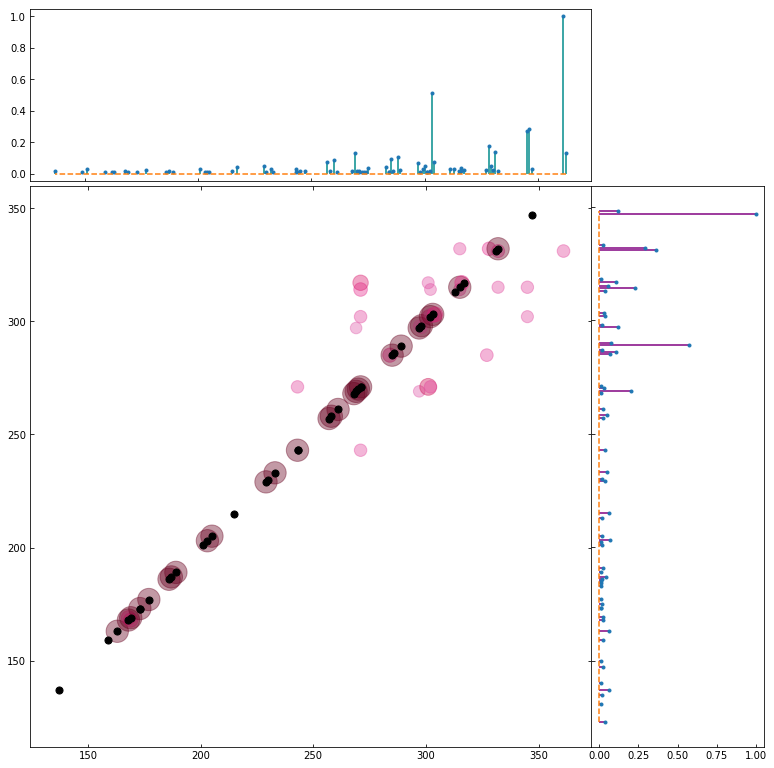

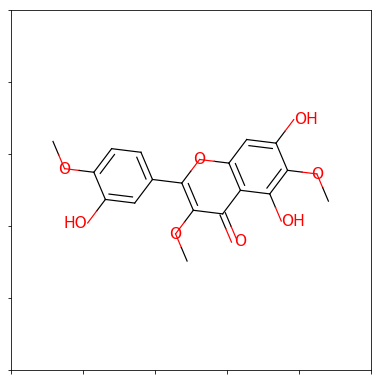

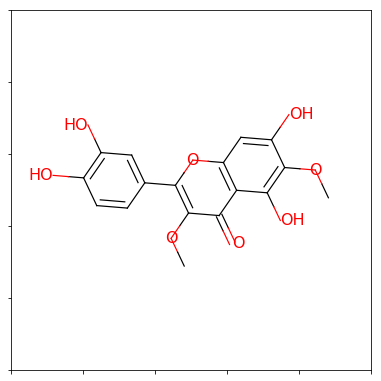

In [41]:
id = 0
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim_hung[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  wordsim_cutoff = 0.5,
                                                  plot_molecules = True)

### Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=high

In [55]:
pair_selection = np.where((cosine_sim > 0.8)
                          & (molnet_sim_hung > 0.9)
                & (M_sim_ctr < 0.4) 
                & (molecular_similarities > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (8,)  matching spectral pairs.


3335 4830
Word2Vec score:  0.3937712626856361
Cosine score:  0.9833451754542634
Modified cosine score:  0.9778307683264843
Molecular similarity:  0.8136882129277566
  Created documents for  2  of  2  spectra.

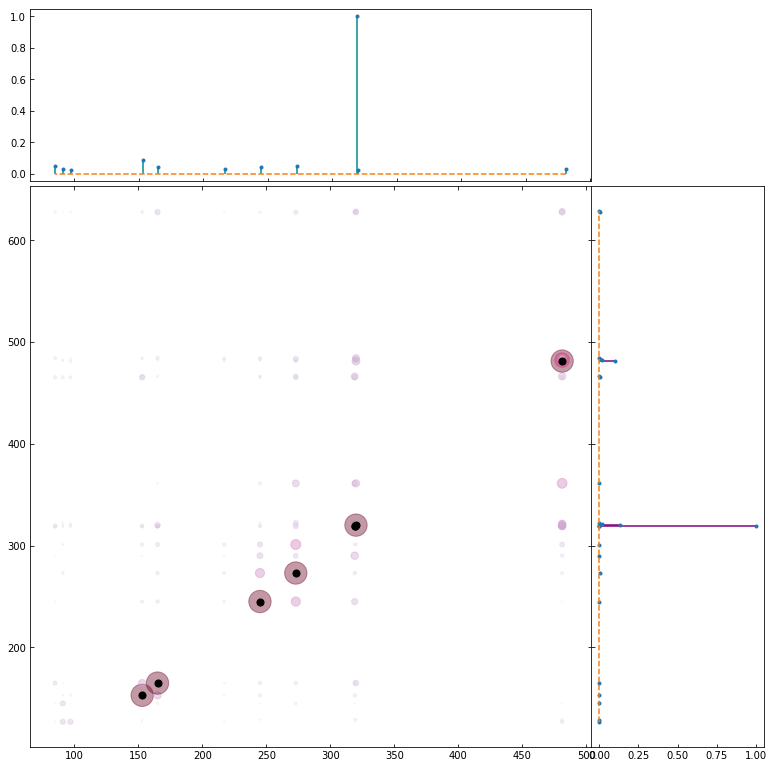

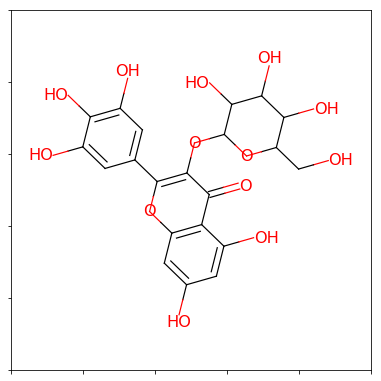

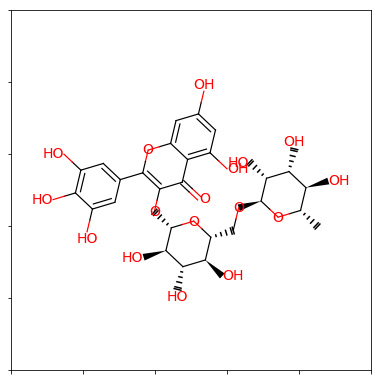

In [56]:
id = 1
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Word2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", cosine_sim[ID1, ID2])
print("Modified cosine score: ", molnet_sim_hung[ID1, ID2])
print("Molecular similarity: ", molecular_similarities[ID1, ID2])

Csim_words = MS_functions.plot_spectra_comparison(MS_measure,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.001,
                                                  wordsim_cutoff = 0.0,
                                                  plot_molecules = True)